In [1]:
# Import necessary libraries for Spark
from pyspark.sql import functions as sparkf
from pyspark.sql import Window as W
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

# Import necessary libraries for data manipulation and visualization
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from functools import reduce

In [2]:
! head -3 000000000000

source,isTrueDirect,sourceKeyword,medium,isVideoAd,fullVisitorId,visitId,date,newVisits,hitReferer,hitType,hitAction_type,hitNumber,hitHour,hitMin,timeMicroSec,v2ProductName,productListName,isClick,isImpression,sessionQualityDim,timeOnScreen,timeOnSite,totalTransactionRevenue
google,true,(not provided),organic,,4988612949713423910,1489617360,20170315,,,PAGE,0,28,15,46,608771,Google Accent Insulated Stainless Steel Bottle,Category,,true,,,1897,
google,true,(not provided),organic,,4988612949713423910,1489617360,20170315,,,PAGE,0,27,15,46,605064,Google Pocket Bluetooth Speaker,Category,,true,,,1897,


In [3]:
# Initialize Spark Session

from pyspark.sql import SparkSession

spark = SparkSession.\
        builder.\
        appName("Social Commerce").\
        master("spark://spark-master:7077").\
        config("spark.executor.memory", "1000m").\
        config("spark.executor.cores", "2").\
        config("spark.cores.max", "6").\
        getOrCreate()

23/05/24 01:19:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [4]:
raw_df = spark.read.option('header','true')\
.option("inferSchema" , "true")\
.format('csv').load('./000000000000')

# 1. Business Understanding

### 1.1 Classification Approach

# 2. Data Understanding

In [5]:
ignoredCols = []
outlierCols = []

### 2.1 สภาพข้อมูลโดยทั่วไป

In [6]:
raw_df.count()

917814

In [7]:
len(raw_df.columns)

24

In [8]:
raw_df.printSchema()

root
 |-- source: string (nullable = true)
 |-- isTrueDirect: boolean (nullable = true)
 |-- sourceKeyword: string (nullable = true)
 |-- medium: string (nullable = true)
 |-- isVideoAd: boolean (nullable = true)
 |-- fullVisitorId: long (nullable = true)
 |-- visitId: integer (nullable = true)
 |-- date: integer (nullable = true)
 |-- newVisits: integer (nullable = true)
 |-- hitReferer: string (nullable = true)
 |-- hitType: string (nullable = true)
 |-- hitAction_type: integer (nullable = true)
 |-- hitNumber: integer (nullable = true)
 |-- hitHour: integer (nullable = true)
 |-- hitMin: integer (nullable = true)
 |-- timeMicroSec: integer (nullable = true)
 |-- v2ProductName: string (nullable = true)
 |-- productListName: string (nullable = true)
 |-- isClick: boolean (nullable = true)
 |-- isImpression: boolean (nullable = true)
 |-- sessionQualityDim: integer (nullable = true)
 |-- timeOnScreen: string (nullable = true)
 |-- timeOnSite: integer (nullable = true)
 |-- totalTransac

In [9]:
raw_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
source,917814,None,None,(direct),youtube.com
sourceKeyword,322031,None,None,(Remarketing/Content targeting),yyoutubr
medium,917814,None,None,(none),referral
fullVisitorId,917814,4.7679506549928141E18,1.42707561410277811E18,514359656957582,5487531102128447544
visitId,917814,1.4828991660307045E9,9692290.975135243,1470037326,1501656575
date,917814,2.0165139267192483E7,4699.035428253384,20160801,20170801
newVisits,647359,1.0,0.0,1,1
hitReferer,119959,None,None,http://googleads.g.doubleclick.net/pagead/ads?...,https://youtube.com/yt/about/copyright/
hitType,917814,None,None,EVENT,PAGE


In [10]:
ignoredCols = ['hitReferer','v2ProductName']

### 2.2 Null Profiling

In [11]:
# Loop over all columns in the dataframe
for a in raw_df.columns:
  # For each column, perform a group by operation. This groups the dataframe by the unique values in the column
  # Then, count the number of occurrences of each unique value
  # Finally, order the results by the count in descending order and display the result
  raw_df.groupBy(a).count().orderBy('count',ascending = False).show()

+--------------------+------+
|              source| count|
+--------------------+------+
|            (direct)|502654|
|              google|320612|
|         youtube.com| 34750|
|            Partners|  9949|
|                 dfa|  8696|
|analytics.google.com|  6144|
|          google.com|  4537|
|    sites.google.com|  3866|
|siliconvalley.abo...|  3399|
|      m.facebook.com|  2283|
|        facebook.com|  2073|
|          reddit.com|  1978|
|     mail.google.com|  1833|
|                bing|  1543|
|           qiita.com|  1496|
|               yahoo|  1441|
|           quora.com|  1252|
|                t.co|   996|
|   groups.google.com|   950|
|      l.facebook.com|   517|
+--------------------+------+
only showing top 20 rows



+------------+------+
|isTrueDirect| count|
+------------+------+
|        null|580491|
|        true|337323|
+------------+------+



+--------------------+------+
|       sourceKeyword| count|
+--------------------+------+
|                null|595783|
|      (not provided)|296422|
|    6qEhsCssdK0z36ri| 12471|
|  Google Merchandise|  2529|
|    1hZbAqLCbjwfgOH7|  2273|
|google merchandis...|  2061|
|    category_l1==166|   457|
|(Remarketing/Cont...|   373|
|    1X4Me6ZKNV0zg-jV|   330|
|googlemerchandise...|   323|
|             youtube|   207|
|+google +merchand...|   201|
|        google merch|   198|
|         google stor|   171|
|       youtube merch|   169|
|+Google +Merchandise|   164|
|Google Merchandis...|   164|
|      +google +store|   162|
|             Youtube|   140|
|        google store|   121|
+--------------------+------+
only showing top 20 rows



+---------+------+
|   medium| count|
+---------+------+
|   (none)|502654|
|  organic|302345|
| referral| 72078|
|      cpc| 21580|
|affiliate|  9949|
|      cpm|  9136|
|(not set)|    72|
+---------+------+



+---------+------+
|isVideoAd| count|
+---------+------+
|     null|885422|
|    false| 32392|
+---------+------+



+-------------------+-----+
|      fullVisitorId|count|
+-------------------+-----+
|5456301402188625337| 3416|
|5208937953046059083| 2377|
|5399906287295745418| 2338|
|5310912563447452038| 1792|
|5370310992308515600| 1777|
|5143600689169444167| 1651|
|5217792392522047587| 1605|
|4998444590527389280| 1550|
|5479405825116961439| 1482|
|5174129705003851738| 1472|
|5341271361784611942| 1443|
|5305785224618680102| 1413|
|5423659711610895780| 1267|
|5002959687839673544| 1211|
|5128888224452873031| 1179|
|5315382266855883329| 1164|
|5457033415990547887| 1143|
| 506797253390432707| 1094|
|5391968741622668774| 1081|
|5031234556107572838| 1081|
+-------------------+-----+
only showing top 20 rows



+----------+-----+
|   visitId|count|
+----------+-----+
|1487093395| 1777|
|1472342843| 1306|
|1474845319|  995|
|1473902040|  986|
|1471629165|  950|
|1474799746|  924|
|1472479074|  920|
|1472343066|  919|
|1473468179|  913|
|1479842010|  867|
|1481587574|  817|
|1478550894|  793|
|1473022577|  790|
|1470432463|  786|
|1471836187|  781|
|1474775547|  779|
|1471884865|  775|
|1471752880|  773|
|1473181908|  755|
|1483021729|  753|
+----------+-----+
only showing top 20 rows



+--------+-----+
|    date|count|
+--------+-----+
|20160815| 8733|
|20160914| 8693|
|20160822| 8214|
|20160831| 7571|
|20160804| 7514|
|20160816| 7394|
|20160811| 7300|
|20160823| 6858|
|20160906| 6836|
|20160921| 6828|
|20160907| 6598|
|20160913| 6506|
|20160812| 6430|
|20160902| 6246|
|20160809| 6237|
|20160817| 6064|
|20160827| 6021|
|20160805| 5946|
|20160802| 5946|
|20160909| 5633|
+--------+-----+
only showing top 20 rows



+---------+------+
|newVisits| count|
+---------+------+
|        1|647359|
|     null|270455|
+---------+------+



+--------------------+------+
|          hitReferer| count|
+--------------------+------+
|                null|797855|
|https://www.googl...| 38623|
|https://www.googl...|  7437|
|https://www.youtu...|  7204|
|https://www.googl...|  6743|
|https://www.googl...|  3560|
|https://www.googl...|  2873|
|https://www.googl...|  2854|
|http://www.google...|  2356|
|https://www.googl...|  1912|
|https://www.googl...|  1909|
|https://www.googl...|  1573|
|https://www.googl...|  1329|
|https://www.googl...|  1200|
|https://www.googl...|   968|
|https://www.googl...|   967|
|https://www.googl...|   845|
|https://www.googl...|   839|
|https://www.googl...|   768|
|https://www.googl...|   764|
+--------------------+------+
only showing top 20 rows



+-------+------+
|hitType| count|
+-------+------+
|   PAGE|886585|
|  EVENT| 31229|
+-------+------+



+--------------+------+
|hitAction_type| count|
+--------------+------+
|             0|853903|
|             1| 22253|
|             2| 18313|
|             5| 12380|
|             3|  6200|
|             6|  3880|
|             4|   885|
+--------------+------+



+---------+------+
|hitNumber| count|
+---------+------+
|        1|128949|
|        3|104988|
|        2|101344|
|        4| 75432|
|        5| 54931|
|        6| 45212|
|        7| 40069|
|        8| 33037|
|        9| 28159|
|       10| 24166|
|       11| 21807|
|       12| 18867|
|       13| 17060|
|       14| 14858|
|       15| 13635|
|       16| 12554|
|       17| 11389|
|       18| 10054|
|       19|  9889|
|       20|  8821|
+---------+------+
only showing top 20 rows



+-------+-----+
|hitHour|count|
+-------+-----+
|     11|64196|
|     10|60383|
|     13|57946|
|     14|54553|
|     12|53822|
|      9|48343|
|      8|45227|
|     16|44962|
|     15|43676|
|     18|39950|
|     17|39395|
|     20|39173|
|      7|37065|
|     22|34531|
|     19|34193|
|     21|33678|
|     23|31245|
|      6|30732|
|      5|24574|
|      0|23328|
+-------+-----+
only showing top 20 rows



+------+-----+
|hitMin|count|
+------+-----+
|    21|16750|
|    43|16699|
|    58|16398|
|    23|16368|
|    52|16307|
|    41|16248|
|    30|16110|
|    57|16085|
|    54|16050|
|    36|15954|
|    56|15943|
|    28|15817|
|    53|15790|
|    26|15789|
|    20|15767|
|     9|15726|
|    35|15698|
|    40|15657|
|     6|15593|
|    42|15579|
+------+-----+
only showing top 20 rows



+------------+------+
|timeMicroSec| count|
+------------+------+
|           0|129394|
|      374888|    80|
|        9553|    80|
|       13598|    80|
|       11300|    80|
|       13027|    80|
|       13796|    79|
|       11756|    79|
|       17138|    73|
|           1|    72|
|       56918|    71|
|        8860|    70|
|       32959|    70|
|       33192|    70|
|       97580|    70|
|       11187|    69|
|        8751|    68|
|      211748|    68|
|       12114|    68|
|        8108|    68|
+------------+------+
only showing top 20 rows



+--------------------+-----+
|       v2ProductName|count|
+--------------------+-----+
|Google Men's 100%...|15365|
|22 oz YouTube Bot...|10277|
|YouTube Men's Sho...|10125|
|YouTube Custom De...| 9866|
|Google Men's 100%...| 9319|
|YouTube Men's Sho...| 9286|
|   YouTube Twill Cap| 9252|
|Google Men's 100%...| 9227|
|Electronics Acces...| 8507|
|YouTube Men's Sho...| 7970|
|YouTube Wool Heat...| 7968|
|Google Laptop and...| 7866|
|YouTube Leatheret...| 7599|
|Google Men's  Zip...| 7392|
| YouTube Trucker Hat| 7285|
|Google Men's Wate...| 7100|
|Suitcase Organize...| 7014|
|Google Men's 100%...| 6847|
|Google Alpine Sty...| 6602|
|Google Men's Vint...| 6565|
+--------------------+-----+
only showing top 20 rows



+----------------+------+
| productListName| count|
+----------------+------+
|        Category|847919|
|Related Products| 28085|
|       (not set)| 23657|
|  Search Results| 18153|
+----------------+------+



+-------+------+
|isClick| count|
+-------+------+
|   null|895561|
|   true| 22253|
+-------+------+

+------------+------+
|isImpression| count|
+------------+------+
|        true|853903|
|        null| 63911|
+------------+------+



+-----------------+------+
|sessionQualityDim| count|
+-----------------+------+
|             null|856032|
|                1| 28967|
|                2|  4177|
|                3|  1816|
|                4|  1641|
|                5|  1529|
|                7|   825|
|                6|   824|
|               68|   679|
|               19|   601|
|               44|   596|
|               10|   596|
|                8|   569|
|               77|   561|
|               76|   492|
|               80|   478|
|               54|   466|
|                9|   462|
|               12|   451|
|               62|   433|
+-----------------+------+
only showing top 20 rows



+------------+------+
|timeOnScreen| count|
+------------+------+
|        null|917814|
+------------+------+



+----------+-----+
|timeOnSite|count|
+----------+-----+
|      null|67305|
|        64| 2333|
|        67| 2264|
|        24| 2246|
|        55| 2230|
|        54| 2214|
|        13| 2212|
|        26| 2210|
|       106| 2188|
|       158| 2174|
|        56| 2120|
|        87| 2120|
|        90| 2119|
|        38| 2117|
|        35| 2113|
|      2469| 2099|
|        86| 2070|
|        52| 2060|
|       215| 2045|
|       169| 2026|
+----------+-----+
only showing top 20 rows



+-----------------------+------+
|totalTransactionRevenue| count|
+-----------------------+------+
|                   null|847514|
|              186860000|   950|
|              220520000|   920|
|              681400000|   817|
|              192440000|   786|
|               81980000|   704|
|              108630000|   671|
|               32950000|   652|
|               79150000|   644|
|              355970000|   626|
|              208640000|   583|
|               80060000|   579|
|              127380000|   577|
|               54000000|   569|
|              150340000|   565|
|              101940000|   556|
|               29980000|   540|
|              216630000|   524|
|              307740000|   522|
|               28980000|   511|
+-----------------------+------+
only showing top 20 rows



In [12]:
from pyspark.sql.functions import col, sum

# Iterating through each column in DataFrame
for col_name in raw_df.columns:
    # Using `isNull()` to create a new DataFrame where each row is either true (if the original value was null) or false
    # Then, using `cast()` to convert booleans to integers (true becomes 1, false becomes 0)
    # And using `sum()` to find the total number of nulls in the column
    null_count = raw_df.select(sum(col(col_name).isNull().cast("int")).alias(col_name)).collect()[0][col_name]
    print(f"The column '{col_name}' has {null_count} null values.")



The column 'source' has 0 null values.


The column 'isTrueDirect' has 580491 null values.


The column 'sourceKeyword' has 595783 null values.


The column 'medium' has 0 null values.


The column 'isVideoAd' has 885422 null values.


The column 'fullVisitorId' has 0 null values.


The column 'visitId' has 0 null values.


The column 'date' has 0 null values.


The column 'newVisits' has 270455 null values.


The column 'hitReferer' has 797855 null values.


The column 'hitType' has 0 null values.
The column 'hitAction_type' has 0 null values.


The column 'hitNumber' has 0 null values.


The column 'hitHour' has 0 null values.


The column 'hitMin' has 0 null values.


The column 'timeMicroSec' has 0 null values.


The column 'v2ProductName' has 0 null values.


The column 'productListName' has 0 null values.
The column 'isClick' has 895561 null values.


The column 'isImpression' has 63911 null values.


The column 'sessionQualityDim' has 856032 null values.
The column 'timeOnScreen' has 917814 null values.


The column 'timeOnSite' has 67305 null values.
The column 'totalTransactionRevenue' has 847514 null values.


In [13]:
ignoredCols = ignoredCols+['timeOnScreen']

In [14]:
ignoredCols

['hitReferer', 'v2ProductName', 'timeOnScreen']

### 2.3 Outlier Profiling

In [15]:
# Importing required data types from PySpark
from pyspark.sql.types import IntegerType, FloatType, LongType, StringType

# Initializing empty lists for numeric and non-numeric columns
numeric_columns = []
non_numeric_columns = []

# Looping through each column in the DataFrame
for col_name in raw_df.columns:
    # Checking if the column data type is numeric (IntegerType, FloatType, or LongType)
    if isinstance(raw_df.schema[col_name].dataType, (IntegerType, FloatType, LongType)):
        # If it is numeric, then add the column name to the numeric_columns list
        numeric_columns.append(col_name)
    else:
        # If it's not numeric, then add the column name to the non_numeric_columns list
        non_numeric_columns.append(col_name)

# Printing the list of numeric columns
print(f"Numeric columns: {numeric_columns}")

# Printing the list of non-numeric columns
print(f"Non-numeric columns: {non_numeric_columns}")

Numeric columns: ['fullVisitorId', 'visitId', 'date', 'newVisits', 'hitAction_type', 'hitNumber', 'hitHour', 'hitMin', 'timeMicroSec', 'sessionQualityDim', 'timeOnSite', 'totalTransactionRevenue']
Non-numeric columns: ['source', 'isTrueDirect', 'sourceKeyword', 'medium', 'isVideoAd', 'hitReferer', 'hitType', 'v2ProductName', 'productListName', 'isClick', 'isImpression', 'timeOnScreen']


In [16]:
from pyspark.sql.functions import col, expr

# Loop through every numeric column
for col_name in numeric_columns:
    # Calculate IQR
    bounds = raw_df.approxQuantile(col_name, [0.25, 0.75], 0.05)
    IQR = bounds[1] - bounds[0]

    # Calculate lower and upper bounds
    lower_bound = bounds[0] - 1.5 * IQR
    upper_bound = bounds[1] + 1.5 * IQR

    # Find outliers
    outliers = raw_df.filter((col(col_name) < lower_bound) | (col(col_name) > upper_bound))

    # Print only the column name, the count of outliers and the outlier range
    print(f"Column: {col_name}")
    print(f"Outlier count: {outliers.count()}")
    print(f"Outlier range: < {lower_bound} OR > {upper_bound}\n")

Column: fullVisitorId


Outlier count: 90805
Outlier range: < 4.644776973901258e+18 OR > 5.788280369053179e+18



Column: visitId


Outlier count: 0
Outlier range: < 1448245415.5 OR > 1516209107.5



Column: date


Outlier count: 0
Outlier range: < 20146788.0 OR > 20184452.0



Column: newVisits


Outlier count: 0
Outlier range: < 1.0 OR > 1.0



Column: hitAction_type


Outlier count: 63911
Outlier range: < 0.0 OR > 0.0



Column: hitNumber


Outlier count: 107855
Outlier range: < -10.5 OR > 25.5



Column: hitHour


Outlier count: 0
Outlier range: < -3.0 OR > 29.0



Column: hitMin


Outlier count: 0
Outlier range: < -27.0 OR > 85.0



Column: timeMicroSec


Outlier count: 108522
Outlier range: < -361549.0 OR > 657971.0



Column: sessionQualityDim


Outlier count: 12166
Outlier range: < -26.0 OR > 46.0



Column: timeOnSite


Outlier count: 70879
Outlier range: < -877.0 OR > 1795.0



Column: totalTransactionRevenue
Outlier count: 8730
Outlier range: < -122395000.0 OR > 308845000.0



In [17]:
outlierCols = ['totalTransactionRevenue','timeOnSite']

### 2.4 Spurious Detection

In [18]:
raw_df\
      .filter((sparkf.col('fullVisitorId') == '516734366347147622')&(sparkf.col('VisitId') == '1478384303'))\
      .select(['fullVisitorId','visitId','hitNumber','hitAction_type'\
               ,'totalTransactionRevenue','v2ProductName','timeMicroSec'])\
      .orderBy('hitNumber').show(1000,truncate=False)

+------------------+----------+---------+--------------+-----------------------+--------------------------------------------------------+------------+
|fullVisitorId     |visitId   |hitNumber|hitAction_type|totalTransactionRevenue|v2ProductName                                           |timeMicroSec|
+------------------+----------+---------+--------------+-----------------------+--------------------------------------------------------+------------+
|516734366347147622|1478384303|6        |0             |70980000               |Rubber Grip Ballpoint Pen 4 Pack                        |62638       |
|516734366347147622|1478384303|6        |0             |70980000               |Ballpoint LED Light Pen                                 |62638       |
|516734366347147622|1478384303|6        |0             |70980000               |Leather and Metal Ballpoint Pen                         |62638       |
|516734366347147622|1478384303|6        |0             |70980000               |Google Stylus 

# 3. Data Preparation

### 3.1 Transform Categorical Columns to Dummy Columns and Null Replacement

In [19]:
noNull_Dummy_df = raw_df.withColumn('isTrueDirect', sparkf.when(raw_df.isTrueDirect == 'true', 1).otherwise(0)) \
.withColumn('medium_organic', sparkf.when(raw_df.medium == 'organic', 1).otherwise(0)) \
.withColumn('dayofweek', sparkf.dayofweek(sparkf.to_date(sparkf.col('date').cast('string'), 'yyyyMMdd'))) \
.withColumn('newVisits', sparkf.when(raw_df.newVisits == '1', 1).otherwise(0)) \
.withColumn('purchased', sparkf.when(raw_df.hitAction_type == 6, 1).otherwise(0)) \
.withColumn('isClick', sparkf.when(raw_df.isClick, 1).otherwise(0)) \
.withColumn('isImpression', sparkf.when(raw_df.isImpression, 1).otherwise(0)) \
.withColumn('hitaction_1', sparkf.when(raw_df.hitAction_type == 1, 1).otherwise(0)) \
.withColumn('hitaction_2', sparkf.when(raw_df.hitAction_type == 2, 1).otherwise(0)) \
.withColumn('hitaction_3', sparkf.when(raw_df.hitAction_type == 3, 1).otherwise(0)) \
.withColumn('hitaction_4', sparkf.when(raw_df.hitAction_type == 4, 1).otherwise(0)) \
.withColumn('hitaction_5', sparkf.when(raw_df.hitAction_type == 5, 1).otherwise(0)) \
.withColumn('hitaction_6', sparkf.when(raw_df.hitAction_type == 6, 1).otherwise(0)) \
.na.fill(value=0, subset=['timeOnSite', 'sessionQualityDim', 'totalTransactionRevenue']) ### ตรงนี้เกิดการแทนที่ null ด้วย 0

In [20]:
noNull_Dummy_df.printSchema()

root
 |-- source: string (nullable = true)
 |-- isTrueDirect: integer (nullable = false)
 |-- sourceKeyword: string (nullable = true)
 |-- medium: string (nullable = true)
 |-- isVideoAd: boolean (nullable = true)
 |-- fullVisitorId: long (nullable = true)
 |-- visitId: integer (nullable = true)
 |-- date: integer (nullable = true)
 |-- newVisits: integer (nullable = false)
 |-- hitReferer: string (nullable = true)
 |-- hitType: string (nullable = true)
 |-- hitAction_type: integer (nullable = true)
 |-- hitNumber: integer (nullable = true)
 |-- hitHour: integer (nullable = true)
 |-- hitMin: integer (nullable = true)
 |-- timeMicroSec: integer (nullable = true)
 |-- v2ProductName: string (nullable = true)
 |-- productListName: string (nullable = true)
 |-- isClick: integer (nullable = false)
 |-- isImpression: integer (nullable = false)
 |-- sessionQualityDim: integer (nullable = true)
 |-- timeOnScreen: string (nullable = true)
 |-- timeOnSite: integer (nullable = true)
 |-- totalTra

### 3.2 Solving Spurious Pattern

In [21]:
noSpurious_df = noNull_Dummy_df.groupBy('fullVisitorId', 'visitId', 
                  'dayofweek',
                  'newVisits'
                  ) \
.agg(sparkf.sum('hitaction_1').alias('sum_hitaction_1')
, sparkf.sum('hitaction_2').alias('sum_hitaction_2')
, sparkf.sum('hitaction_3').alias('sum_hitaction_3')
, sparkf.sum('hitaction_4').alias('sum_hitaction_4')
, sparkf.sum('hitaction_5').alias('sum_hitaction_5')
, sparkf.sum('hitaction_6').alias('sum_hitaction_6')
, sparkf.max('hitNumber').alias('hitNumber')
, sparkf.max('timeOnSite').alias('timeOnSite')
, sparkf.max('totalTransactionRevenue').alias('totalTransactionRevenue')
, sparkf.max('isClick').alias('isClick')
, sparkf.max('isImpression').alias('isImpression')
)\
.withColumn('target', sparkf.when(sparkf.col('sum_hitaction_6') >= 1, 1).otherwise(0))


In [22]:
noSpurious_df.printSchema()

root
 |-- fullVisitorId: long (nullable = true)
 |-- visitId: integer (nullable = true)
 |-- dayofweek: integer (nullable = true)
 |-- newVisits: integer (nullable = false)
 |-- sum_hitaction_1: long (nullable = true)
 |-- sum_hitaction_2: long (nullable = true)
 |-- sum_hitaction_3: long (nullable = true)
 |-- sum_hitaction_4: long (nullable = true)
 |-- sum_hitaction_5: long (nullable = true)
 |-- sum_hitaction_6: long (nullable = true)
 |-- hitNumber: integer (nullable = true)
 |-- timeOnSite: integer (nullable = true)
 |-- totalTransactionRevenue: long (nullable = true)
 |-- isClick: integer (nullable = true)
 |-- isImpression: integer (nullable = true)
 |-- target: integer (nullable = false)



In [23]:
noSpurious_df.filter((sparkf.col('fullVisitorId') == '516734366347147622')&(sparkf.col('VisitId') == '1478384303'))\
.select(['fullVisitorId','visitId','dayofweek','newVisits','hitNumber'\
               ,'timeOnSite','totalTransactionRevenue'])\
.orderBy('hitNumber').show(1000,truncate=False)

23/05/24 01:22:03 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------------------+----------+---------+---------+---------+----------+-----------------------+
|fullVisitorId     |visitId   |dayofweek|newVisits|hitNumber|timeOnSite|totalTransactionRevenue|
+------------------+----------+---------+---------+---------+----------+-----------------------+
|516734366347147622|1478384303|7        |1        |59       |1196      |70980000               |
+------------------+----------+---------+---------+---------+----------+-----------------------+



In [24]:
noSpurious_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
fullVisitorId,22983,4.7503920939082527E18,1.4495176761477696E18,514359656957582,5487531102128447544
visitId,22983,1.4866869404499848E9,9177392.88893765,1470037326,1501656575
dayofweek,22983,3.9555758604185702,1.8575551036454476,1,7
newVisits,22983,0.7410259757211852,0.43808084792949115,0,1
sum_hitaction_1,22983,0.968237392855589,2.784369119878886,0,97
sum_hitaction_2,22983,0.7968063351172606,2.385787093037114,0,99
sum_hitaction_3,22983,0.2697646086237654,1.2243266292848105,0,34
sum_hitaction_4,22983,0.03850672236000522,0.3808190239489791,0,19
sum_hitaction_5,22983,0.5386590088326154,4.492228281877536,0,240


# 4. Modeling

### 4.1 Feature Selection

In [25]:
df = noSpurious_df.toPandas()

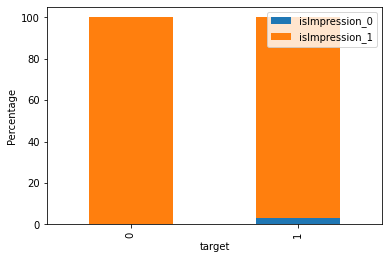

In [26]:
# Initialize parameters
x_var = 'target'  # Variable to be displayed on x-axis
groupby_var = 'isImpression'  # Variable to group data by

# Group the data by target variable and count the values of "isImpression" variable
# This gives us a series where the index is a MultiIndex (x_var, groupby_var) and the values are the counts of each group
grouped = df.groupby(x_var)[groupby_var].value_counts()

# Calculate the percentage for each group
# For each level 0 index (x_var), we normalize the counts to sum up to 100
grouped_pct = grouped.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

# Create a figure and an axis for the plot
fig, ax = plt.subplots()

# Create a 100% stacked bar chart
# .unstack() turns the MultiIndex series into a DataFrame
# We then plot this data frame as a stacked bar plot
grouped_pct.unstack().plot(kind='bar', stacked=True, ax=ax)

# Adjust x and y labels
ax.set_xlabel(x_var)  # Label for x-axis
ax.set_ylabel('Percentage')  # Label for y-axis

# Name each part of the stack bar
# Generate legend labels based on the column names of the data frame (which are the unique values of groupby_var)
legend_labels = [f'{groupby_var}_{label}' for label in grouped_pct.unstack().columns]
ax.legend(legend_labels)  # Add legend to the plot

# Display the plot
plt.show()


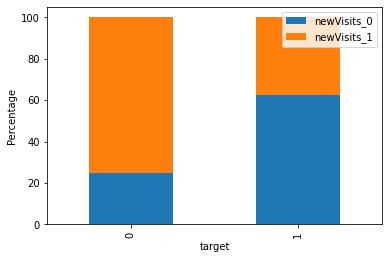

In [27]:
# Initialize parameters
x_var = 'target'  # Variable to be displayed on x-axis
groupby_var = 'newVisits'  # Variable to group data by

# Group the data by target variable and count the values of "isImpression" variable
# This gives us a series where the index is a MultiIndex (x_var, groupby_var) and the values are the counts of each group
grouped = df.groupby(x_var)[groupby_var].value_counts()

# Calculate the percentage for each group
# For each level 0 index (x_var), we normalize the counts to sum up to 100
grouped_pct = grouped.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

# Create a figure and an axis for the plot
fig, ax = plt.subplots()

# Create a 100% stacked bar chart
# .unstack() turns the MultiIndex series into a DataFrame
# We then plot this data frame as a stacked bar plot
grouped_pct.unstack().plot(kind='bar', stacked=True, ax=ax)

# Adjust x and y labels
ax.set_xlabel(x_var)  # Label for x-axis
ax.set_ylabel('Percentage')  # Label for y-axis

# Name each part of the stack bar
# Generate legend labels based on the column names of the data frame (which are the unique values of groupby_var)
legend_labels = [f'{groupby_var}_{label}' for label in grouped_pct.unstack().columns]
ax.legend(legend_labels)  # Add legend to the plot

# Display the plot
plt.show()


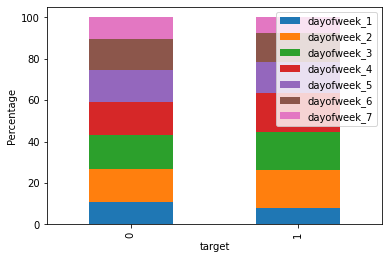

In [28]:
# Initialize parameters
x_var = 'target'  # Variable to be displayed on x-axis
groupby_var = 'dayofweek'  # Variable to group data by

# Group the data by target variable and count the values of "isImpression" variable
# This gives us a series where the index is a MultiIndex (x_var, groupby_var) and the values are the counts of each group
grouped = df.groupby(x_var)[groupby_var].value_counts()

# Calculate the percentage for each group
# For each level 0 index (x_var), we normalize the counts to sum up to 100
grouped_pct = grouped.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

# Create a figure and an axis for the plot
fig, ax = plt.subplots()

# Create a 100% stacked bar chart
# .unstack() turns the MultiIndex series into a DataFrame
# We then plot this data frame as a stacked bar plot
grouped_pct.unstack().plot(kind='bar', stacked=True, ax=ax)

# Adjust x and y labels
ax.set_xlabel(x_var)  # Label for x-axis
ax.set_ylabel('Percentage')  # Label for y-axis

# Name each part of the stack bar
# Generate legend labels based on the column names of the data frame (which are the unique values of groupby_var)
legend_labels = [f'{groupby_var}_{label}' for label in grouped_pct.unstack().columns]
ax.legend(legend_labels)  # Add legend to the plot

# Display the plot
plt.show()


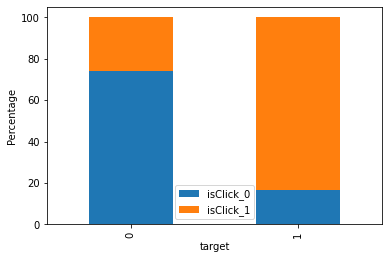

In [29]:
# Initialize parameters
x_var = 'target'  # Variable to be displayed on x-axis
groupby_var = 'isClick'  # Variable to group data by

# Group the data by target variable and count the values of "isImpression" variable
# This gives us a series where the index is a MultiIndex (x_var, groupby_var) and the values are the counts of each group
grouped = df.groupby(x_var)[groupby_var].value_counts()

# Calculate the percentage for each group
# For each level 0 index (x_var), we normalize the counts to sum up to 100
grouped_pct = grouped.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

# Create a figure and an axis for the plot
fig, ax = plt.subplots()

# Create a 100% stacked bar chart
# .unstack() turns the MultiIndex series into a DataFrame
# We then plot this data frame as a stacked bar plot
grouped_pct.unstack().plot(kind='bar', stacked=True, ax=ax)

# Adjust x and y labels
ax.set_xlabel(x_var)  # Label for x-axis
ax.set_ylabel('Percentage')  # Label for y-axis

# Name each part of the stack bar
# Generate legend labels based on the column names of the data frame (which are the unique values of groupby_var)
legend_labels = [f'{groupby_var}_{label}' for label in grouped_pct.unstack().columns]
ax.legend(legend_labels)  # Add legend to the plot

# Display the plot
plt.show()


In [30]:
def plot_outliers_and_distribution(df, var, target='target'):
    """
    This function plots a boxplot to check outliers and a violin plot to see the distribution
    grouped by the target variable in one figure.
    
    Parameters:
    df (DataFrame): Input pandas DataFrame
    var (str): Variable/column to check
    target (str): Target variable. Default is 'target'
    """
    
    # Import necessary libraries
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Create a figure with two subplots (1 row, 2 columns), and set the figure size
    fig, axs = plt.subplots(ncols=2, figsize=(14, 6))

    # Boxplot for outliers:
    # Boxplot is used to visualize the distribution of a variable and its potential outliers.
    # The x-axis is the target variable, and the y-axis is the variable to be checked.
    sns.boxplot(x=target, y=var, data=df, ax=axs[0])
    axs[0].set_title(f'Boxplot of {var} Grouped by {target}')  # Set the title of the first subplot

    # Violin plot for distribution:
    # Violin plot is a combination of a boxplot and a kernel density plot, it shows the distribution of the data.
    # The x-axis is the target variable, and the y-axis is the variable to be checked.
    sns.violinplot(x=target, y=var, data=df, ax=axs[1])
    axs[1].set_title(f'Violin plot of {var} Grouped by {target}')  # Set the title of the second subplot

    # Adjust the layout so that the plots do not overlap
    plt.tight_layout()
    
    # Display the plots
    plt.show()

# To use the function, simply call it with your DataFrame and variable:
# plot_outliers_and_distribution(df, 'timeOnSite')


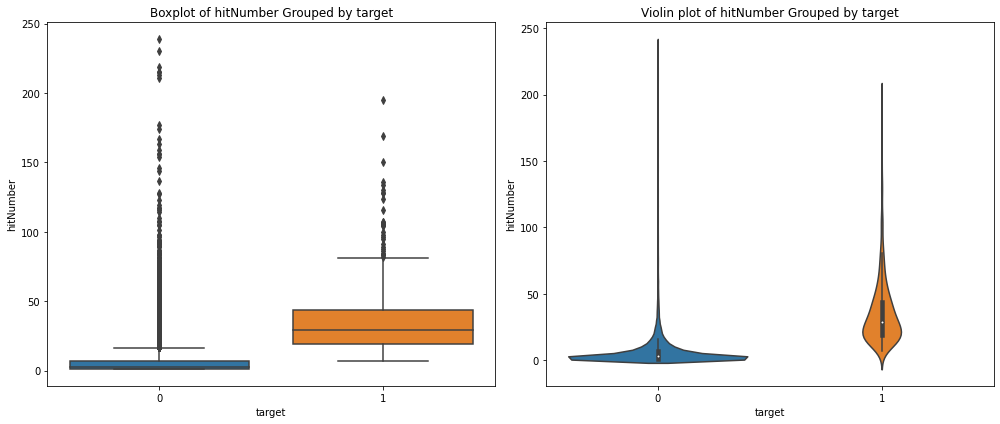

In [31]:
plot_outliers_and_distribution(df, 'hitNumber')

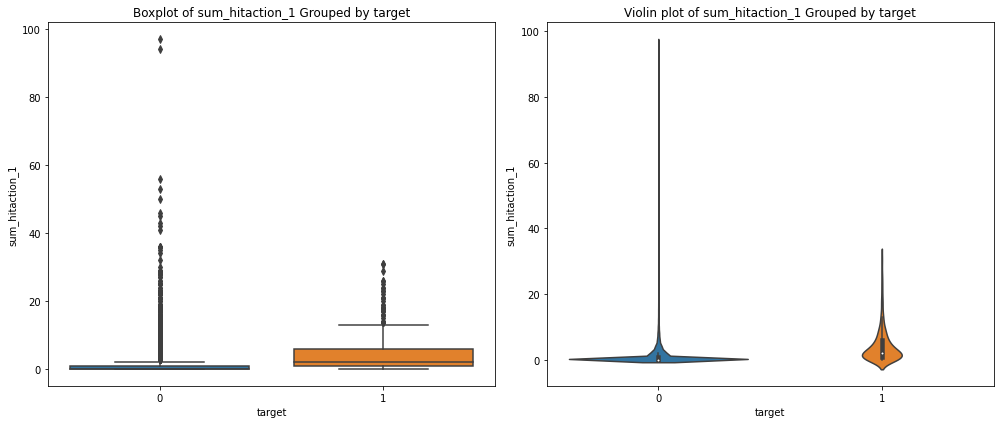

In [32]:
plot_outliers_and_distribution(df, 'sum_hitaction_1')

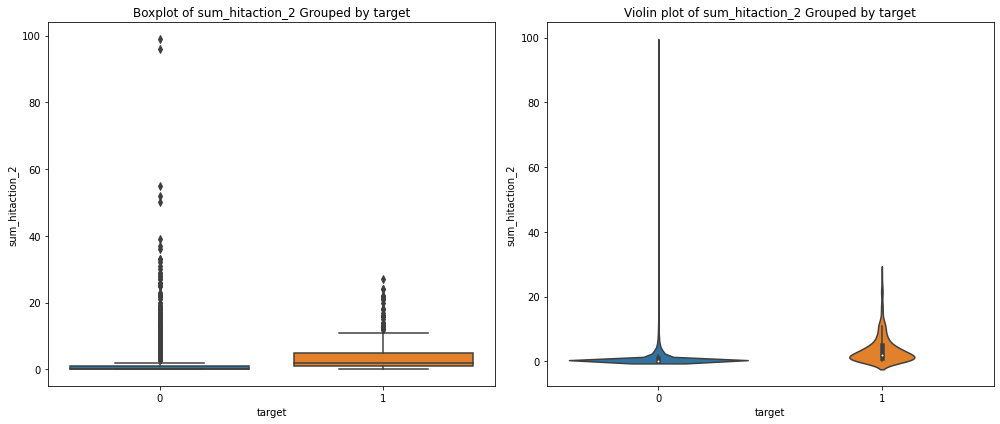

In [33]:
plot_outliers_and_distribution(df, 'sum_hitaction_2')

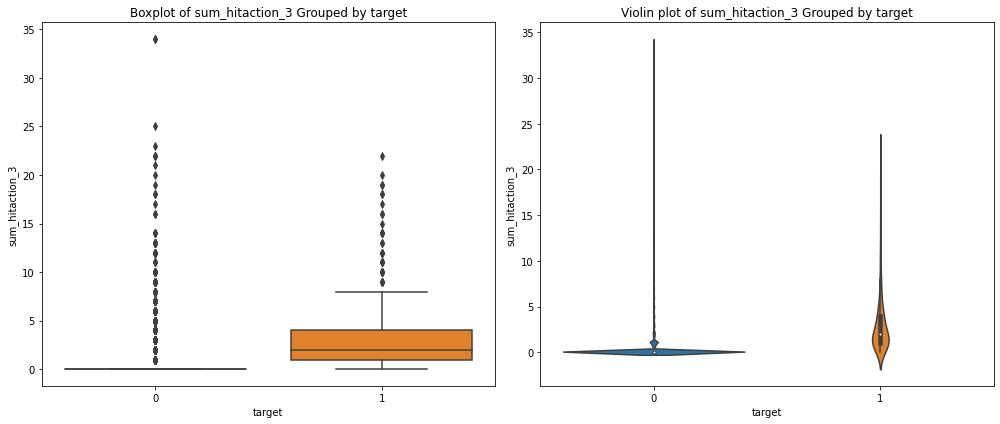

In [34]:
plot_outliers_and_distribution(df, 'sum_hitaction_3')

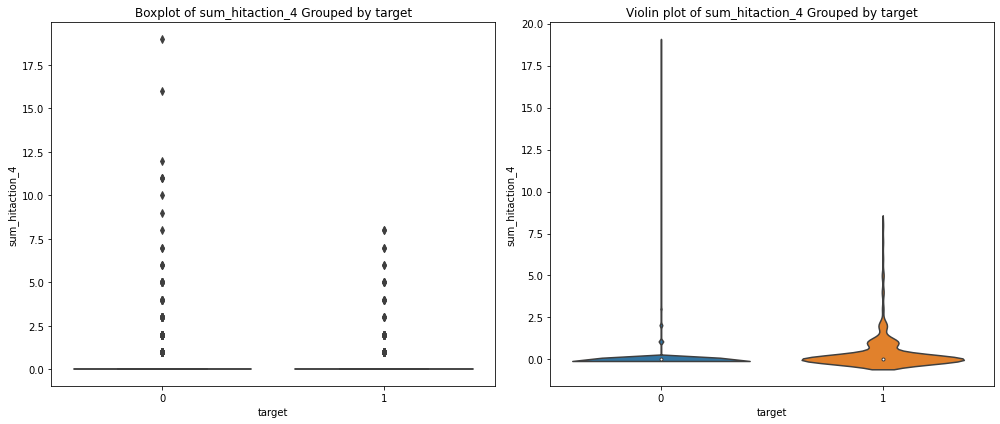

In [35]:
plot_outliers_and_distribution(df, 'sum_hitaction_4')

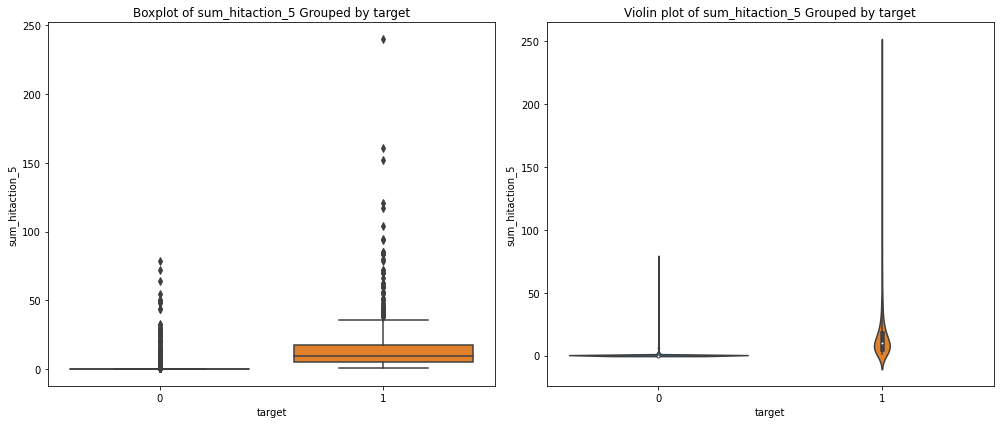

In [36]:
plot_outliers_and_distribution(df, 'sum_hitaction_5')

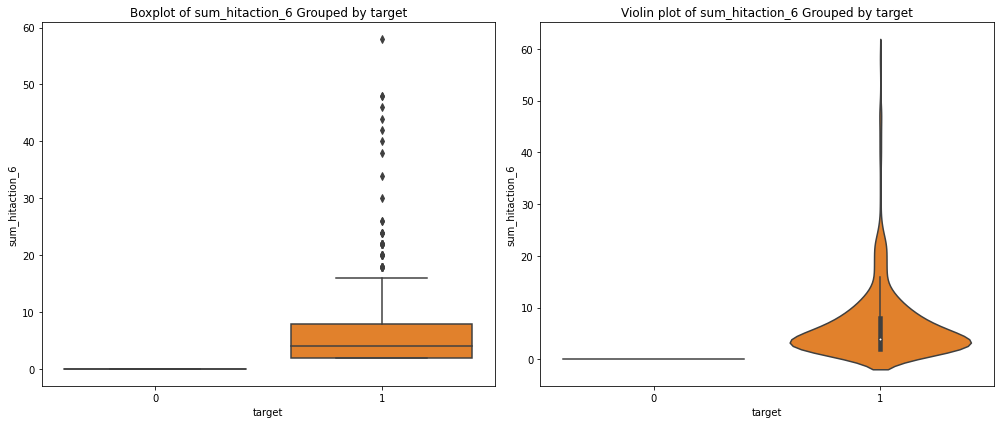

In [37]:
plot_outliers_and_distribution(df, 'sum_hitaction_6')

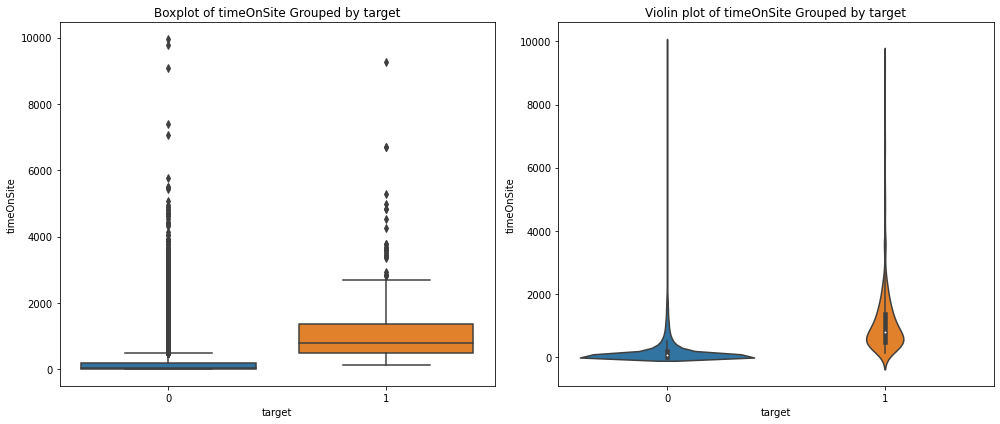

In [38]:
plot_outliers_and_distribution(df, 'timeOnSite')

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

def scatter_plot_with_hue(dataframe, x_var, y_var, hue_var):
    """
    This function creates a scatter plot with a coloring based on the `hue_var` parameter.
    
    Parameters:
    dataframe (DataFrame): Input pandas DataFrame
    x_var (str): Variable/column for x-axis
    y_var (str): Variable/column for y-axis
    hue_var (str): Variable/column to color data points
    """
    # Create a new figure and set the size
    plt.figure(figsize=(10, 6))

    # Create a scatter plot with x_var on the x-axis, and y_var on the y-axis
    # hue_var is used to differentiate points with different colors
    sns.scatterplot(x=x_var, y=y_var, hue=hue_var, data=dataframe)

    # Add labels to the x and y axes, and a title to the plot
    plt.xlabel(x_var)  # Label for x-axis
    plt.ylabel(y_var)  # Label for y-axis
    plt.title('Scatter Plot of {} vs. {}, by {}'.format(x_var, y_var, hue_var))  # Title of the plot

    # Display the plot
    plt.show()

# To use the function, simply call it with your DataFrame and variable:
# scatter_plot_with_hue(df, 'variable1', 'variable2', 'hue_variable')


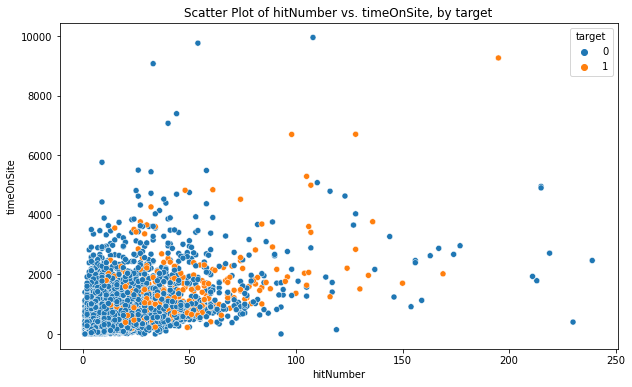

In [40]:
scatter_plot_with_hue(df, 'hitNumber', 'timeOnSite', 'target')

In [41]:
featureTrainingCols = ['isImpression','hitNumber','sum_hitaction_1','sum_hitaction_2','timeOnSite']

In [42]:
#ABT_df = noSpurious_df.select(featureTrainingCols+['target'])

ABT_df = noSpurious_df

In [43]:
ABT_df.printSchema()

root
 |-- fullVisitorId: long (nullable = true)
 |-- visitId: integer (nullable = true)
 |-- dayofweek: integer (nullable = true)
 |-- newVisits: integer (nullable = false)
 |-- sum_hitaction_1: long (nullable = true)
 |-- sum_hitaction_2: long (nullable = true)
 |-- sum_hitaction_3: long (nullable = true)
 |-- sum_hitaction_4: long (nullable = true)
 |-- sum_hitaction_5: long (nullable = true)
 |-- sum_hitaction_6: long (nullable = true)
 |-- hitNumber: integer (nullable = true)
 |-- timeOnSite: integer (nullable = true)
 |-- totalTransactionRevenue: long (nullable = true)
 |-- isClick: integer (nullable = true)
 |-- isImpression: integer (nullable = true)
 |-- target: integer (nullable = false)



### 4.2 แบ่งแยก Analytical Based Table เป็น training และ testing set

In [44]:
train_df, test_df = ABT_df.randomSplit([0.8, 0.2], seed=49)
print("Training Dataset: " + str(train_df.count()))
print("Test Dataset: " + str(test_df.count()))

Training Dataset: 18306


Test Dataset: 4677


In [45]:
train_df.groupBy('target').count().show()

+------+-----+
|target|count|
+------+-----+
|     1|  447|
|     0|17859|
+------+-----+



In [46]:
test_df.groupBy('target').count().show()

+------+-----+
|target|count|
+------+-----+
|     1|  126|
|     0| 4551|
+------+-----+



### 4.3 แก้ไข Imbalance Class

In [47]:
balanceRatio = train_df.filter(sparkf.col('target') == 1).count() / train_df.count()

In [48]:
balanceRatio


0.02441822353326778

In [49]:
calWeight = sparkf.udf(lambda x: 1 * balanceRatio if x == 0 else (1 * (1.0 - balanceRatio)), DoubleType())

In [50]:
weighted_df = train_df.withColumn('class_weight', calWeight('target'))

In [51]:
weighted_df.groupBy('target','class_weight').count().show()

+------+-------------------+-----+
|target|       class_weight|count|
+------+-------------------+-----+
|     0|0.02441822353326778|17859|
|     1| 0.9755817764667323|  447|
+------+-------------------+-----+



### 4.4 Pipeline Training

In [52]:
weighted_df.printSchema()

root
 |-- fullVisitorId: long (nullable = true)
 |-- visitId: integer (nullable = true)
 |-- dayofweek: integer (nullable = true)
 |-- newVisits: integer (nullable = false)
 |-- sum_hitaction_1: long (nullable = true)
 |-- sum_hitaction_2: long (nullable = true)
 |-- sum_hitaction_3: long (nullable = true)
 |-- sum_hitaction_4: long (nullable = true)
 |-- sum_hitaction_5: long (nullable = true)
 |-- sum_hitaction_6: long (nullable = true)
 |-- hitNumber: integer (nullable = true)
 |-- timeOnSite: integer (nullable = true)
 |-- totalTransactionRevenue: long (nullable = true)
 |-- isClick: integer (nullable = true)
 |-- isImpression: integer (nullable = true)
 |-- target: integer (nullable = false)
 |-- class_weight: double (nullable = true)



In [53]:
weighted_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
fullVisitorId,18306,4.7510356106492959E18,1.44736742636336282E18,514359656957582,5487531102128447544
visitId,18306,1.4866916254648204E9,9192689.08935552,1470037326,1501656575
dayofweek,18306,3.9480498197312355,1.855819013479741,1,7
newVisits,18306,0.7393750682836229,0.4389875896189457,0,1
sum_hitaction_1,18306,0.9687534141811428,2.7753955347614427,0,97
sum_hitaction_2,18306,0.7958592811100186,2.3644009878467487,0,99
sum_hitaction_3,18306,0.2646673221894461,1.2049857009172475,0,34
sum_hitaction_4,18306,0.03840270949415492,0.38177569959061397,0,19
sum_hitaction_5,18306,0.5242543428384137,4.423273670365526,0,240


In [54]:
test_df.printSchema()

root
 |-- fullVisitorId: long (nullable = true)
 |-- visitId: integer (nullable = true)
 |-- dayofweek: integer (nullable = true)
 |-- newVisits: integer (nullable = false)
 |-- sum_hitaction_1: long (nullable = true)
 |-- sum_hitaction_2: long (nullable = true)
 |-- sum_hitaction_3: long (nullable = true)
 |-- sum_hitaction_4: long (nullable = true)
 |-- sum_hitaction_5: long (nullable = true)
 |-- sum_hitaction_6: long (nullable = true)
 |-- hitNumber: integer (nullable = true)
 |-- timeOnSite: integer (nullable = true)
 |-- totalTransactionRevenue: long (nullable = true)
 |-- isClick: integer (nullable = true)
 |-- isImpression: integer (nullable = true)
 |-- target: integer (nullable = false)



In [55]:
test_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
fullVisitorId,4677,4.7478733388384E18,1.45805605230641766E18,5134451956558008,5487207201083085422
visitId,4677,1.486668603079538E9,9118231.031720918,1470062934,1501649054
dayofweek,4677,3.9850331409022877,1.8642414364609876,1,7
newVisits,4677,0.7474877057943126,0.434499943777512,0,1
sum_hitaction_1,4677,0.9662176608937353,2.8195161233611206,0,94
sum_hitaction_2,4677,0.8005131494547787,2.467967528743928,0,96
sum_hitaction_3,4677,0.2897156296771435,1.2971999952146938,0,23
sum_hitaction_4,4677,0.038913833654051745,0.3770914538389531,0,12
sum_hitaction_5,4677,0.5950395552704725,4.752582588129257,0,117


In [56]:
vector_assembler = VectorAssembler(inputCols = featureTrainingCols, outputCol = 'features')

RFC = RandomForestClassifier(labelCol='target', featuresCol='features', weightCol='class_weight', seed=49)

In [57]:
pipeline = Pipeline(stages=[vector_assembler, RFC])

In [58]:
rfModel = pipeline.fit(weighted_df)

# 5. Model Evaluation

### 5.1 Performance Measurement

In [59]:
result_df = rfModel.transform(test_df.dropna())

In [60]:
result_df.groupBy('target','prediction').count().show()

+------+----------+-----+
|target|prediction|count|
+------+----------+-----+
|     1|       0.0|    6|
|     0|       0.0| 4072|
|     1|       1.0|  120|
|     0|       1.0|  479|
+------+----------+-----+



In [61]:
#test_df.groupBy('totalTransactionRevenue','target').count().show(1000)

In [62]:
# Calculate confusion matrix
confusion_matrix = result_df.groupBy('target', 'prediction').count()

# Fetch values from confusion matrix
TP = confusion_matrix.filter((sparkf.col('target') == 1) & (sparkf.col('prediction') == 1.0)).select('count').collect()[0][0]
FP = confusion_matrix.filter((sparkf.col('target') == 0) & (sparkf.col('prediction') == 1.0)).select('count').collect()[0][0]
FN = confusion_matrix.filter((sparkf.col('target') == 1) & (sparkf.col('prediction') == 0.0)).select('count').collect()[0][0]
TN = confusion_matrix.filter((sparkf.col('target') == 0) & (sparkf.col('prediction') == 0.0)).select('count').collect()[0][0]

### 5.2 Success Criterias

In [63]:
# Calculate metrics
recall = TP / (TP + FN) # Sensitivity or True Positive Rate
specificity = TN / (TN + FP) # Specificity or True Negative Rate
ppv = TP / (TP + FP) # Positive Predictive Value (PPV) or Precision
npv = TN / (TN + FN) # Negative Predictive Value (NPV)

print("Recall (Sensitivity):", recall)
print("Specificity:", specificity)
print("PPV (Precision):", ppv)
print("NPV:", npv)

Recall (Sensitivity): 0.9523809523809523
Specificity: 0.8947484069435289
PPV (Precision): 0.2003338898163606
NPV: 0.9985286905345758


In [64]:
rfModel.stages[1]

RandomForestClassificationModel: uid=RandomForestClassifier_0a287b9a5e3a, numTrees=20, numClasses=2, numFeatures=5

In [66]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Initialize the hyperparameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(RFC.numTrees, [20, 50, 100]) \
    .build()

# Set up 5-fold cross-validation
crossval = CrossValidator(estimator=pipeline, 
                          estimatorParamMaps=paramGrid, 
                          evaluator=BinaryClassificationEvaluator(labelCol="target"),  # Specify the correct name of target column
                          numFolds=5) 

# Fit the model
cvModel = crossval.fit(weighted_df)

# Use the best model to generate predictions on the test data
result_cv_df = cvModel.transform(test_df.dropna())

# Evaluate the model's performance
evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='target', metricName='areaUnderROC')  # Specify the correct name of target column
print('Area Under ROC = %g' % evaluator.evaluate(result_cv_df))


Area Under ROC = 0.921477
